<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Week_3/Tugas_3_Tensorflow_CIFAR_10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TUGAS WEEK 3 CNN & MLP menggunakan PyTorch**
1. Buat model Deep learning CNN dan MLP (PyTorch and Tensorflow). Ambil datasets dari tensorflow_datasets dan torchvision.datasets
2. Gunakan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC)
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Akurasi pada Training dan Testing Set Minimal Sebesar 75%. untuk model MLP Vanila bebas dapet akurasi berapapun
5. Disarankan untuk mengerjakan tugas menggunakan Google Colab. Coba gunakan Google Colab dengan
     T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.

In [19]:
!pip install -q tensorflow tensorflow_datasets matplotlib scikit-learn pandas seaborn

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Set random seed untuk reproduktibilitas
np.random.seed(42)

In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_datasets as tfds

# Set random seed untuk TensorFlow
tf.random.set_seed(42)

# Cek ketersediaan GPU
print("TensorFlow version:", tf.__version__)
print("GPU tersedia:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Untuk menampilkan informasi GPU jika tersedia (dengan penanganan error yang lebih baik)
if len(tf.config.list_physical_devices('GPU')) > 0:
    try:
        # Gunakan command shell untuk mendapatkan info GPU
        !nvidia-smi
    except:
        print("Tidak dapat menampilkan detail GPU, tetapi GPU terdeteksi.")

TensorFlow version: 2.18.0
GPU tersedia: []
Num GPUs Available:  0


### **Persiapan Dataset CIFAR-10**

In [22]:
# Memuat dataset CIFAR-10 langsung dari TensorFlow Keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalisasi piksel gambar ke rentang [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Konversi label ke bentuk one-hot encoding
y_train_oh = to_categorical(y_train, num_classes=10)
y_test_oh = to_categorical(y_test, num_classes=10)

# Definisi nama-nama kelas untuk visualisasi dan interpretasi
labels_cifar10 = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

# Cetak informasi dasar dataset
print(f"Data training: {x_train.shape[0]} sampel")
print(f"Data testing: {x_test.shape[0]} sampel")
print(f"Jumlah kelas: {len(labels_cifar10)}")
print(f"Label CIFAR-10: {labels_cifar10}")
print(f"Dimensi gambar per sampel: {x_train.shape[1:]}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Data training: 50000 sampel
Data testing: 10000 sampel
Jumlah kelas: 10
Label CIFAR-10: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
Dimensi gambar per sampel: (32, 32, 3)


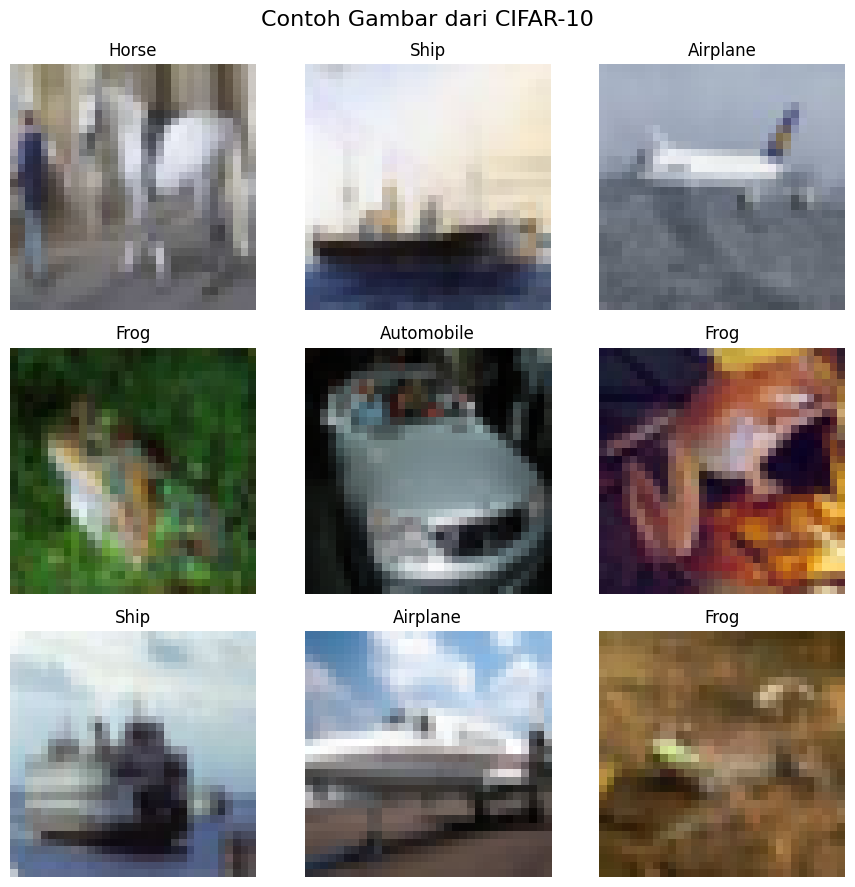

In [23]:
# Fungsi untuk menampilkan grid gambar dari dataset
def show_sample_images(data, labels, label_names, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    selected_idx = np.random.choice(data.shape[0], rows * cols, replace=False)

    for ax, idx in zip(axes.flat, selected_idx):
        ax.imshow(data[idx])
        label_index = labels[idx][0] if labels.ndim == 2 else labels[idx]
        ax.set_title(label_names[label_index])
        ax.axis('off')

    plt.suptitle("Contoh Gambar dari CIFAR-10", fontsize=16)
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan sampel gambar dari data pelatihan
show_sample_images(x_train, y_train, labels_cifar10, rows=3, cols=3)


### **MODEL CNN**

In [24]:
# Fungsi untuk membangun arsitektur CNN CIFAR-10
def build_cnn():
    model = tf.keras.Sequential()

    # Blok Conv 1
    model.add(layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))

    # Blok Conv 2
    model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))

    # Blok Conv 3
    model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))

    # Fully Connected Layer
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))

    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Inisialisasi model CNN
cnn_model = build_cnn()

# Tampilkan arsitektur model
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,738 (506.79 KB)

 Trainable params: 129,290 (505.04 KB)

 Non-trainable params: 448 (1.75 KB)

### **Model MLP**

In [25]:
# Membangun model MLP sederhana untuk klasifikasi CIFAR-10
def build_mlp():
    model = tf.keras.Sequential()

    # Flatten input layer
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Flatten())

    # Hidden dense layers
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(10, activation='softmax'))

    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Inisialisasi dan tampilkan ringkasan model
mlp_model = build_mlp()
mlp_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,676,682 (14.03 MB)

 Trainable params: 3,676,682 (14.03 MB)

 Non-trainable params: 0 (0.00 B)

### **Fungsi Pelatihan Model**

In [26]:
# Callback: Early Stopping untuk menghentikan pelatihan saat tidak ada peningkatan
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback: Simpan model terbaik berdasarkan val_loss
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_cifar10_tf.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# TensorBoard (opsional, bisa aktifkan kalau pakai log)
log_dir = "./logs"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Gabungkan semua callback
callbacks_used = [stop_early, save_best]  # Tambahkan tensorboard_cb jika mau logging ke TensorBoard


### **Fungsi Pelatihan Model**

In [27]:
# Fungsi Evaluasi Lengkap
def evaluate_classification(model, X_data, y_data, y_ohe, labels):
    # Prediksi probabilitas dan label
    probas = model.predict(X_data)
    predictions = np.argmax(probas, axis=1)
    true_labels = y_data.flatten()

    # Metrik evaluasi
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions, average='macro')
    rec = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    print(f"📊 Accuracy      : {acc:.4f}")
    print(f"🎯 Precision     : {prec:.4f}")
    print(f"📈 Recall        : {rec:.4f}")
    print(f"🏅 F1 Score      : {f1:.4f}")

    # Confusion matrix
    conf_mat = confusion_matrix(true_labels, predictions)

    # ROC & AUC untuk setiap kelas
    num_classes = len(labels)
    roc_scores = {}
    fprs, tprs = {}, {}

    for i in range(num_classes):
        fprs[i], tprs[i], _ = roc_curve(y_ohe[:, i], probas[:, i])
        roc_scores[i] = auc(fprs[i], tprs[i])

    # Rata-rata AUC
    mean_auc = np.mean(list(roc_scores.values()))
    print(f"🔵 Macro Average AUC: {mean_auc:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "macro_auc": mean_auc,
        "conf_matrix": conf_mat,
        "roc_auc_classwise": roc_scores,
        "fpr": fprs,
        "tpr": tprs
    }

### **Training Menggunakan Model CNN**

In [30]:
print("🚀 Memulai pelatihan model CNN...")

start_cnn = time.perf_counter()

history_cnn = cnn_model.fit(
    x=x_train,
    y=y_train_oh,
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks_used,
    verbose=1
)

end_cnn = time.perf_counter()
elapsed = end_cnn - start_cnn
print(f"✅ Pelatihan selesai dalam {elapsed:.2f} detik.")

🚀 Memulai pelatihan model CNN...
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6110 - loss: 1.0841
Epoch 1: val_loss improved from 5.74498 to 1.02682, saving model to best_model_cifar10_tf.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 136s 386ms/step - accuracy: 0.6110 - loss: 1.0839 - val_accuracy: 0.6368 - val_loss: 1.0268
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6829 - loss: 0.9014
Epoch 2: val_loss improved from 1.02682 to 0.90965, saving model to best_model_cifar10_tf.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 134s 364ms/step - accuracy: 0.6830 - loss: 0.9014 - val_accuracy: 0.6832 - val_loss: 0.9096
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7235 - loss: 0.7805
Epoch 3: val_loss improved from 0.90965 to 0.89096, saving model to best_model_cifar10_tf.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 146s 377ms/step - accuracy: 0.7236 - loss: 0.7804 - val_accuracy: 0.6938 - val_loss: 0.8910
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/ste

### **Test Model**

In [34]:
# --------------------------------
# Evaluasi performa model CNN
# --------------------------------
print("\n🔍 Mengevaluasi model CNN pada dataset uji...")

cnn_results = evaluate_classification(cnn_model,x_test, y_test, y_test_oh, labels_cifar10)


🔍 Mengevaluasi model CNN pada dataset uji...
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
📊 Accuracy      : 0.6763
🎯 Precision     : 0.6943
📈 Recall        : 0.6763
🏅 F1 Score      : 0.6724
🔵 Macro Average AUC: 0.9540


Visualisasi

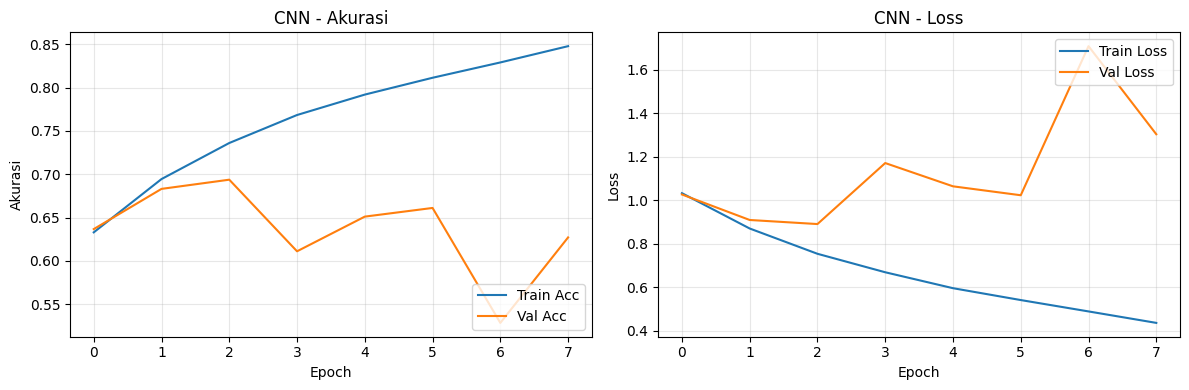

In [35]:
# Fungsi untuk visualisasi kurva training dan validasi
def visualize_training_curves(logs, title):
    plt.figure(figsize=(12, 4))

    # Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(logs.history['accuracy'], label='Train Acc')
    plt.plot(logs.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Akurasi')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(logs.history['loss'], label='Train Loss')
    plt.plot(logs.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
# Visualisasi hasil training CNN
visualize_training_curves(history_cnn, "CNN")


### **Training Model MLP**

In [40]:
print("⚙️ Mulai proses training model MLP...")

start_mlp = time.perf_counter()

history_mlp = mlp_model.fit(
    x=x_train,
    y=y_train_oh,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks_used,
    verbose=1
)

end_mlp = time.perf_counter()
duration = end_mlp - start_mlp
print(f"✅ Training MLP selesai dalam waktu {duration:.2f} detik.")


⚙️ Mulai proses training model MLP...
Epoch 1/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2565 - loss: 2.0078
Epoch 1: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.2566 - loss: 2.0077 - val_accuracy: 0.3278 - val_loss: 1.8730
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2977 - loss: 1.9122
Epoch 2: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.2977 - loss: 1.9122 - val_accuracy: 0.3644 - val_loss: 1.7944
Epoch 3/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3180 - loss: 1.8577
Epoch 3: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.3180 - loss: 1.8577 - val_accuracy: 0.3610 - val_loss: 1.7844
Epoch 4/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3380 - loss: 1.8108
Epoch 4: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.3380 - loss:

### **Evaluasi Model MLP**

**Penjelasan semua persamaan matematika** yang berkaitan dengan **training dan evaluasi model CNN dan MLP**:

---

## **Training Model (CNN & MLP)**

### 1. **Forward Propagation dan Aktivasi**

#### a. **Fungsi Aktivasi ReLU (Rectified Linear Unit)**
Digunakan di hidden layer CNN & MLP:
$$
\text{ReLU}(x) = \max(0, x)
$$

- ReLU menjaga nilai positif dan mengubah nilai negatif menjadi nol.
- Membantu menghindari vanishing gradient.

---

#### b. **Fungsi Aktivasi Softmax (Output Layer)**
Softmax mengubah output menjadi probabilitas:
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$
- $\ z_i $: output neuron ke-i
- $\ K $: jumlah kelas
- Hasilnya adalah distribusi probabilitas, jumlahnya = 1.

---

### 2. **Fungsi Loss: Categorical Cross-Entropy**

Loss yang digunakan:
$$
\mathcal{L}(y, \hat{y}) = - \sum_{i=1}^{K} y_i \log(\hat{y}_i)
$$

- $\ y_i $: label asli (one-hot encoded)
- $\ \hat{y}_i $: probabilitas prediksi dari softmax

Loss ini mengukur jarak antara distribusi target dan prediksi.

---

### 3. **Optimisasi: Adam Optimizer**
Adam menggabungkan RMSProp dan Momentum:

- Update bobot menggunakan:
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
\theta_{t+1} = \theta_t - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

- $\ g_t $: gradien dari loss
- $\ \theta $: parameter/bobot
- $\ \alpha $: learning rate

---

## 📊 **Evaluasi Model**

### 1. **Accuracy (Akurasi)**
Mengukur proporsi prediksi yang benar:
$$
\text{Accuracy} = \frac{\text{Jumlah prediksi benar}}{\text{Total data}}
$$

---

### 2. **Precision (Presisi) - Macro Average**
$$
\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
$$

- $\ TP_i $: True Positive untuk kelas ke-i
- $\ FP_i $: False Positive untuk kelas ke-i

$$
\text{Macro Precision} = \frac{1}{K} \sum_{i=1}^{K} \text{Precision}_i
$$

---

### 3. **Recall (Sensitivitas) - Macro Average**
$$
\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
$$

- $\ FN_i $: False Negative

$$
\text{Macro Recall} = \frac{1}{K} \sum_{i=1}^{K} \text{Recall}_i
$$

---

### 4. **F1-Score - Macro Average**
F1 menggabungkan precision dan recall:
$$
\text{F1}_i = 2 \cdot \frac{\text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
$$

$$
\text{Macro F1} = \frac{1}{K} \sum_{i=1}^{K} \text{F1}_i
$$

---

### 5. **Confusion Matrix**
Sebuah matriks $\ K \times K $ yang memperlihatkan jumlah prediksi benar dan salah antar kelas:
- Baris: Kelas sebenarnya
- Kolom: Kelas prediksi

### 6. **ROC Curve dan AUC (Area Under Curve)**

#### a. **ROC (Receiver Operating Characteristic) Curve**
Grafik antara **True Positive Rate (TPR)** vs **False Positive Rate (FPR)**

$$
\text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}
$$

#### b. **AUC (Area Under Curve)**
Luas di bawah kurva ROC.
- Nilai AUC = 1: model sempurna
- Nilai AUC = 0.5: model acak

---

## ✨ Ringkasan
| Metode | Rumus |
|--------|-------|
| **ReLU** | $\ \max(0, x) $ |
| **Softmax** | $\ \frac{e^{z_i}}{\sum e^{z_j}} $ |
| **Cross Entropy** | $\ -\sum y_i \log(\hat{y}_i) $ |
| **Accuracy** | $\ \frac{\text{benar}}{\text{total}} $ |
| **Precision** | $\ \frac{TP}{TP + FP} $ |
| **Recall** | $\ \frac{TP}{TP + FN} $ |
| **F1-Score** | $\ 2 \cdot \frac{\text{Prec} \cdot \text{Rec}}{\text{Prec} + \text{Rec}} $ |
| **AUC ROC** | Luas antara ROC curve dan sumbu x |

---

Kalau kamu butuh diagram atau visualisasi penjelasan matematis juga (misalnya ROC curve, arsitektur CNN/MLP), tinggal bilang aja!